# Thermochemical benchmark: atomisation of closed shell molecules with core correlation

Bak et al., [doi:10.1063/1.1357225](https://doi.org/10.1063/1.1357225) and [doi:10.1063/1.481544](https://doi.org/10.1063/1.481544)

In [1]:
import pymolpro
import pandas as pd

In [2]:
backend = 'local'  # If preferred, change this to one of the backends in your ~/.sjef/molpro/backends.xml that is ssh-accessible
project_name = 'Bak2000_atomisations'
parallel = None  # how many jobs to run at once

In [3]:
methods = ['UHF', 'UMP2', 'UCCSD', 'UCCSD(T)' ]
bases = ['cc-pCVDZ', 'cc-pCVTZ', 'cc-pCVQZ', 'cc-pCV5Z']

In [4]:
db = pymolpro.database.load("Bak2000_atomisations")

In [5]:
results = {}
for method in methods:
    results[method] = {}
    for basis in bases:
        results[method][basis] = pymolpro.database.run(db, method=method, basis=basis, location=project_name,
                                                       backend=backend,
                                                       core_correlation="small", parallel=parallel)

In [6]:
for method in methods:
    for result in pymolpro.database.basis_extrapolate(results[method].values(), results['UHF'].values()):
        results[method][result.basis] = result
    for basis in results[method]:
        if basis not in bases: bases.append(basis)

In [7]:
pd.set_option('display.precision', 2)
method_errors=pymolpro.database.analyse([results[method]['cc-pCV[45]Z'] for method in methods], db, 'kj/mol')[
    'reaction statistics']
with open(project_name + '.method_errors.tex', 'w') as tf:
    tf.write('\\ifx\\toprule\\undefined\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}\\fi') # or \usepackage{booktabs}
    tf.write(method_errors.style.format(precision=2).to_latex(hrules=True,multicol_align='c',caption='Method errors'))
method_errors

,UHF/cc-pCV[45]Z,UMP2/cc-pCV[45]Z,UCCSD/cc-pCV[45]Z,UCCSD(T)/cc-pCV[45]Z
MAD,405.05,35.11,28.50,0.90
MAXD,598.79,112.20,58.55,2.45
RMSD,428.32,43.60,32.62,1.09
MSD,-405.05,30.04,-28.48,0.08
STDEVD,143.84,32.64,16.43,1.12


In [8]:
pd.set_option('display.precision', 2)
basis_errors=pymolpro.database.analyse([results['UCCSD(T)'][basis] for basis in bases], db, 'kj/mol')[
    'reaction statistics']
with open(project_name + '.basis_errors.tex', 'w') as tf:
    tf.write('\\ifx\\toprule\\undefined\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}\\fi') # or \usepackage{booktabs}
    tf.write(basis_errors.style.format(precision=2).to_latex(hrules=True,multicol_align='c',caption='Basis errors'))
basis_errors

,UCCSD(T)/cc-pCVDZ,UCCSD(T)/cc-pCVTZ,UCCSD(T)/cc-pCVQZ,UCCSD(T)/cc-pCV5Z,UCCSD(T)/cc-pCV[23]Z,UCCSD(T)/cc-pCV[34]Z,UCCSD(T)/cc-pCV[45]Z
MAD,103.07,34.00,13.46,6.61,14.74,1.68,0.90
MAXD,155.71,51.58,20.15,10.71,29.53,4.01,2.45
RMSD,109.18,36.45,14.52,7.25,16.76,2.10,1.09
MSD,-103.07,-34.00,-13.46,-6.61,-14.66,-0.23,0.08
STDEVD,37.19,13.58,5.63,3.08,8.39,2.15,1.12


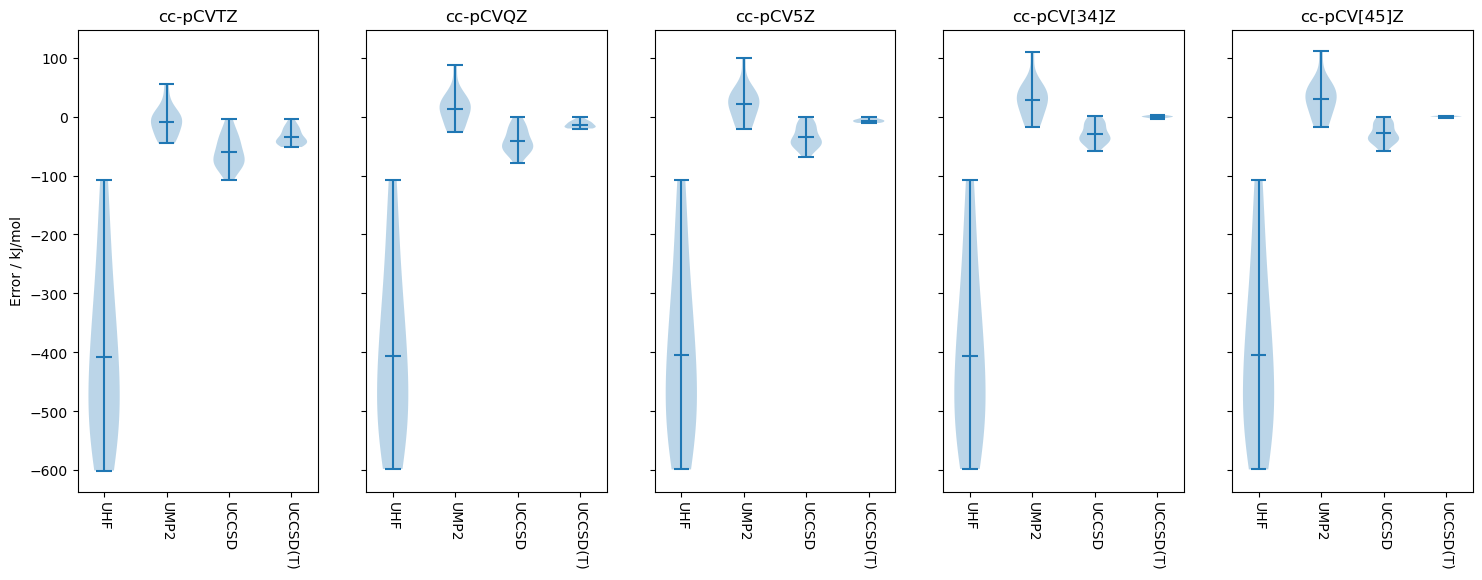

In [9]:
import matplotlib.pyplot as plt

methods_pruned = [method for method in methods if method != 'HF']
bases_pruned = ['cc-pCVTZ', 'cc-pCVQZ', 'cc-pCV5Z', 'cc-pCV[34]Z', 'cc-pCV[45]Z']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18, 6))

for pane in range(len(bases_pruned)):
    data = []
    for method in methods_pruned:
        data.append(
            pymolpro.database.analyse(results[method][bases_pruned[pane]],
                                      db,'kJ/mol')['reaction energy deviations'].to_numpy()[:, 0]
        )
    panes[pane].violinplot(data, showmeans=True, showextrema=True, vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1, len(methods_pruned) + 1), labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name + ".violin.pdf")
